### Cargar un modelo Word2Vec pre-entrenado para el español

ver: https://github.com/dccuchile/spanish-word-embeddings

In [1]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="data/luis/FN_PLU_2017-2021_Twitter_def_v1.csv"
df = pd.read_csv(dataset)



In [14]:
df.size

91188

In [25]:
noticias = df.Message[df["tipoT"].isin([2,3])]

print(noticias)

0       📲 15 tuits políticos que envejecieron mal: jug...
1       En “Contigo en la Mañana” se dio un extraña co...
2       🤦🏻‍♂️ ¿Otra más? Servel desmintió "fake news" ...
3       Otra fake news: Servel desmiente fraude electo...
4       Antivacunas irrumpió en despacho de Contigo en...
                              ...                        
5359    Trump asegura que información "comprometedora"...
5360    Trump asegura que información "comprometedora"...
5361    Trump asegura que información "comprometedora"...
5362    Trump asegura que información "comprometedora"...
5363    RT @Catambiana: #MatinalRVF la desinformación ...
Name: Message, Length: 5240, dtype: object


In [26]:
len(noticias)



5240

In [27]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens


In [28]:
import re
# Remove Emails
noticias = [re.sub(r'\S*@\S*\s?', '', sent) for sent in noticias]

# Remove new line characters
noticias = [re.sub(r'\s+', ' ', sent) for sent in noticias]

# Remove distracting single quotes
noticias= [re.sub("\'", "", sent) for sent in noticias]

# Remove links
noticias = [re.sub(r'\S*http\S*\s?', '', sent) for sent in noticias]
noticias = [re.sub(r'\S*https\S*\s?', '', sent) for sent in noticias]


In [8]:
noticias[0]

'📲 15 tuits políticos que envejecieron mal: jugoso compilado de un año de elecciones, fake news y malas decisiones. '

In [29]:
documents=[]
for noticia in noticias:
    documents.append(spacy_tokenizer(noticia))

In [30]:
etm_documents=[]
for document in documents:
    etm_documents.append(" ".join(document))

In [31]:
documents[1]

['mañana', 'extraño', 'conversación', 'persona', '👇']

In [32]:

etm_documents[1]


'mañana extraño conversación persona 👇'

In [33]:
import re
from sklearn.feature_extraction.text import CountVectorizer
myStopWords=['gnl','=','$','+','a','e','o','u','y',' ','  ','   ','    ']
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words=myStopWords,tokenizer=spacy_tokenizer, ngram_range=(1,1))
tf = tf_vectorizer.fit_transform(etm_documents)
diccionario= tf_vectorizer.get_feature_names()

In [34]:
print(diccionario)

['-&gt', '-diputado', '10%', '100%', '11.15am', '150%', '16%', '2021|', '21:13', '24horascentral', '24horascl', '24play', '25-o', '4,3%', '52%', '5⃣', '70%', '76%', '7pmnosomosnadacq', '8:30', '92.9fm', '99%', 'abandonar', 'abbagliati', 'abbott', 'abedrapo', 'abierto', 'abocar', 'abogada', 'abogado', 'abordar', 'aborto', 'abrazar', 'abrazo', 'abril', 'abrir', 'absolución', 'absolutamente', 'absoluto', 'absolver', 'absuelve', 'abundar', 'aburrir', 'abuso', 'acabar', 'academia', 'académico', 'acaso', 'acceder', 'acceso', 'accidente', 'accio', 'accionista', 'acción', 'acelerado', 'aceptar', 'acerca', 'aclaración', 'aclarar', 'acle', 'acoger', 'acompañar', 'aconsejar', 'acordar', 'acostumbrado', 'acostumbrar', 'acreditado', 'actitud', 'activar', 'activo', 'acto', 'actor', 'actriz', 'actual', 'actualidad', 'actualización', 'actualmente', 'actuar', 'acuartelamiento', 'acudar', 'acudir', 'acusación', 'acusado', 'acusar', 'acá', 'acádemico', 'adherent', 'adido', 'adiós', 'adjudicar', 'administ

In [35]:
from embedded_topic_model.utils import preprocessing
import json

# Preprocessing the dataset
diccionario, train_dataset,test_dataset, = preprocessing.create_etm_datasets(
    etm_documents, 
    min_df=0.01, 
    max_df=0.75, 
    train_size=0.85, 
)



In [65]:
numk = range(10,100,10)
numk

range(10, 100, 10)

In [72]:
from embedded_topic_model.models.etm import ETM
numIt = range(50,1000,100)
perp = []
for n in numIt:
    etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=3,
        epochs=n,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

    etm_instance.fit(train_dataset, test_dataset)
    perp.append(etm_instance._perplexity(test_dataset))


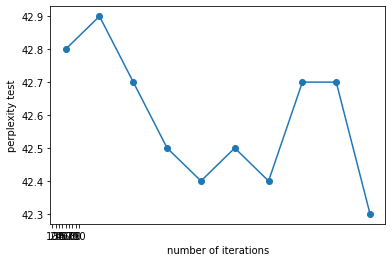

In [73]:
plt.plot(numIt, perp, '-o')
plt.xlabel('number of iterations')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

In [50]:
print(etm_instance._perplexity(test_dataset))

43.9


In [36]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance
perp =[]
numk = range(1,12)
for k in numk:
    etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=k,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

    etm_instance.fit(train_dataset, test_dataset)
    perp.append(etm_instance._perplexity(test_dataset))



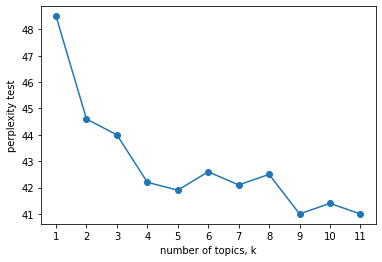

In [37]:
import matplotlib.pyplot as plt
plt.plot(numk, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

In [38]:
from embedded_topic_model.models.etm import ETM
etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=4,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

etm_instance.fit(train_dataset, test_dataset)

In [39]:
import numpy as np
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=4
nDoc = len(dist)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)
print(topics)

[['desinformación', 'social', 'red', 'campaña', 'falso', 'noticia', 'él', 'chile', 'gobierno', 'coronavirus', 'circular', 'acusar', 'piñera', 'rt', 'pandemia', 'año', 'facebook', 'político', 'opinión', 'plebiscito'], ['falso', 'noticia', 'new', 'fake', 'podcast', 'trump', 'elección', 'capítulo', 'carrera', 'vallejo', 'gonzalo', 'igtv', 'martínez', 'lamesa13', 'presidencial', 'camila', 'conversar', 'historia', 'the', 'electoral'], ['falso', 'noticia', 'información', 'difundir', 'facebook', 'rt', 'difusión', 'entregar', 'incendio', 'whatsapp', 'twitter', 'persona', 'bolsonaro', 'fiscalía', 'video', 'denuncia', 'corte', 'arancibio', 'brasil', 'vacuna'], ['fake', 'new', 'desmentir', 'news', 'rt', 'kast', 'boric', 'mentira', 'diputado', 'vivo', 'pedir', 'canal', 'caso', 'chile', 'venezuela', 'ley', 'haber', 'audio', 'video', 'proyecto']]


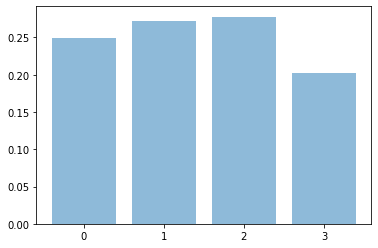

[0.13417748, 0.07713855, 0.07366679, 0.05115798, 0.04461638, 0.041499503, 0.029939327, 0.029199647, 0.022794021, 0.022501323, 0.021924434, 0.018830976, 0.018826298, 0.018757058, 0.018420422]


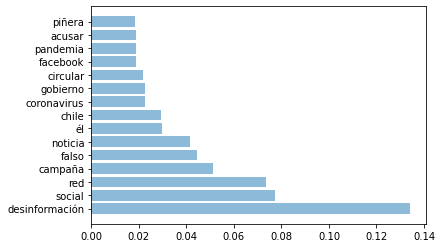

[0.25622487, 0.24298719, 0.028207429, 0.02555591, 0.019918544, 0.01862066, 0.016596753, 0.014732894, 0.014515074, 0.014348766, 0.012744728, 0.011834674, 0.011247185, 0.009149567, 0.009103712]


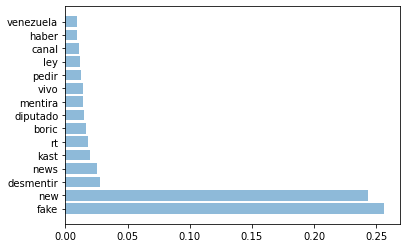

[0.2624194, 0.15981062, 0.11720049, 0.03303773, 0.02511328, 0.022763228, 0.018909032, 0.018537797, 0.016307103, 0.013801909, 0.013621333, 0.013355522, 0.011424891, 0.011240907, 0.011042927]


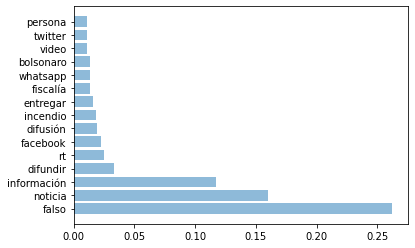

[0.09292538, 0.073355, 0.05500994, 0.053085808, 0.036434542, 0.030634282, 0.025993722, 0.025797317, 0.022971231, 0.022706414, 0.021955773, 0.021789787, 0.02150646, 0.019664358, 0.018166846]


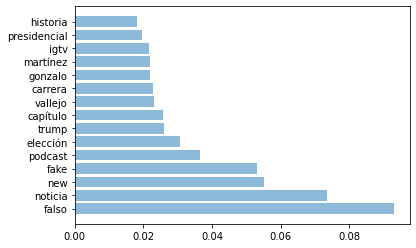

In [82]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
#plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
#show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()



In [40]:
doc_l = np.zeros(len(train_dataset['counts']))
term_f= np.zeros(len(diccionario))
for i in range(0,len(train_dataset['counts'])):
        for j in range(0,len(train_dataset['counts'][i])):
                js = train_dataset['tokens'][i][j]
             
                term_f[js] = term_f[js] + train_dataset['counts'][i][j]
                doc_l[i] = doc_l[i]+ train_dataset['counts'][i][j]

In [42]:
import pyLDAvis
prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

In [43]:
topic_coherence = etm_instance.get_topic_coherence()
print(topic_coherence)
topic_diversity = etm_instance.get_topic_diversity()
print(topic_diversity)
print(etm_instance._perplexity(test_dataset))


-0.053288865146810485
0.84
42.2


/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its